# Пет-проект по анализу данных олимпийских пловцов с 1896 по 2016 годы

В данном пет-проекте я возьму данные "120 years of Olympic history: athletes and results" с платформы Kaggle, отберу записи о спортсменах-пловцах, очищу и исследую их, попробую выявить различные закономерности и предсказать, получит ли атлет медаль в заплыве при помощи логистической регрессии.

## Импорт необходимых библиотек

In [195]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import scipy.stats
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import re

%matplotlib inline

## Загрузка данных

In [196]:
events = pd.read_csv("athlete_events.csv")
region = pd.read_csv("noc_regions.csv")

Датасет events содержит в себе данные об олимпийских спортсменах и имеет следующие поля:
- ID - Unique number for each athlete
- Name - Athlete's name
- Sex - M or F
- Age - Integer
- Height - In centimeters
- Weight - In kilograms
- Team - Team name
- NOC - National Olympic Committee 3-letter code
- Games - Year and season
- Year - Integer
- Season - Summer or Winter
- City - Host city
- Sport - Sport
- Event - Event
- Medal - Gold, Silver, Bronze, or NA

Так как я увлекаюсь плаванием, я буду исследовать атлетов-пловцов:

In [197]:
# отберем записи с видом спорта Swimming
swimmers = events.query("Sport == 'Swimming'")

In [198]:
# посмотрим на данные
swimmers.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
29,10,"Einar Ferdinand ""Einari"" Aalto",M,26.0,NaN,NaN,Finland,FIN,1952 Summer,1952,Summer,Helsinki,Swimming,Swimming Men's 400 metres Freestyle,NaN
35,15,Arvo Ossian Aaltonen,M,22.0,NaN,NaN,Finland,FIN,1912 Summer,1912,Summer,Stockholm,Swimming,Swimming Men's 200 metres Breaststroke,NaN
36,15,Arvo Ossian Aaltonen,M,22.0,NaN,NaN,Finland,FIN,1912 Summer,1912,Summer,Stockholm,Swimming,Swimming Men's 400 metres Breaststroke,NaN
37,15,Arvo Ossian Aaltonen,M,30.0,NaN,NaN,Finland,FIN,1920 Summer,1920,Summer,Antwerpen,Swimming,Swimming Men's 200 metres Breaststroke,Bronze
38,15,Arvo Ossian Aaltonen,M,30.0,NaN,NaN,Finland,FIN,1920 Summer,1920,Summer,Antwerpen,Swimming,Swimming Men's 400 metres Breaststroke,Bronze


In [199]:
# отобразим информацию о таблице
swimmers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23195 entries, 29 to 271088
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      23195 non-null  int64  
 1   Name    23195 non-null  object 
 2   Sex     23195 non-null  object 
 3   Age     22671 non-null  float64
 4   Height  19150 non-null  float64
 5   Weight  18804 non-null  float64
 6   Team    23195 non-null  object 
 7   NOC     23195 non-null  object 
 8   Games   23195 non-null  object 
 9   Year    23195 non-null  int64  
 10  Season  23195 non-null  object 
 11  City    23195 non-null  object 
 12  Sport   23195 non-null  object 
 13  Event   23195 non-null  object 
 14  Medal   3048 non-null   object 
dtypes: float64(3), int64(2), object(10)
memory usage: 2.8+ MB


In [200]:
# количество пропусков в столбцах
swimmers.isna().sum()

ID            0
Name          0
Sex           0
Age         524
Height     4045
Weight     4391
Team          0
NOC           0
Games         0
Year          0
Season        0
City          0
Sport         0
Event         0
Medal     20147
dtype: int64

In [201]:
# уникальные значения в стобце Medal
swimmers.Medal.unique()

array([nan, 'Bronze', 'Silver', 'Gold'], dtype=object)

В данных отсутствуют некоторые значения возраста, роста и веса. Также не у всех спортсменов есть медали.

In [202]:
region.head()

,NOC,region,notes
0,AFG,Afghanistan,NaN
1,AHO,Curacao,Netherlands Antilles
2,ALB,Albania,NaN
3,ALG,Algeria,NaN
4,AND,Andorra,NaN


In [203]:
region.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230 entries, 0 to 229
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   NOC     230 non-null    object
 1   region  227 non-null    object
 2   notes   21 non-null     object
dtypes: object(3)
memory usage: 5.5+ KB


Таблица region сопоставляет значение трехзначного кода NOC и регион Национального олимпийского комитета

# Исследовательский анализ данных и проверка гипотез

Для начала проверим как соотносятся датасеты между собой. Посмотрим на наличие соответствий одного NOC кода разным командам:

In [204]:
swimmers.loc[:, ['NOC', 'Team']].drop_duplicates()['NOC'].value_counts().head()

USA    5
FRA    4
GER    2
FIN    1
BLR    1
Name: NOC, dtype: int64

Значение USA указывает на 5 различных команд. Для того, чтобы понимать из какой страны команда, объединим фреймы по NOC коду и получим новое поле region со страной команды:

In [205]:
swimmers = swimmers.merge(region, how='left', on='NOC')

В датасете многие спортсмены соревновались в нескольких играх, а также в нескольких заплывах. Фактически одна строчка данных - один участник конкретного заплыва

## Соотношение количества атлетов мужского и женского пола

In [206]:
# группируем по полу и считаем уникальные ID, так как не исключено наличие однофамильцев
data_by_sex = swimmers.groupby('Sex', as_index=False).agg(unique_athlete=('ID', 'nunique'))
px.bar(data_by_sex, x=data_by_sex.Sex, y=data_by_sex.unique_athlete)

Как видим, **мужчин** больше

## Распределение возраста спортсменов в разбивке по полу

В данном случае будем рассматривать возраст отдельного участника для каждого сезона:

In [207]:
px.histogram(swimmers.groupby(['ID', 'Year', 'Sex'], as_index=False).agg({'Age': 'min'}).dropna(), x='Age', color='Sex')

На этой гистограмме можно выделить нужный пол на самом графике. Шкала count на общем виде показывает численные значения без разбивки по полу (в возрасете 19 лет у нас всего 2546 атлетов). Можно заметить различия между этими распределениями, но делать вывод по графику я не буду. Я проверю это с помощью статистики

**Мужчины:**

In [208]:
mans_age = swimmers.groupby(['ID', 'Year', 'Sex'], as_index=False).agg({'Age': 'min'}).dropna().query('Sex == "M"')
px.histogram(mans_age, x='Age')

In [209]:
# размер выборки
mans_age.Age.size

6749

In [210]:
# стандартное отклонение
np.std(mans_age.Age)

3.6238062021232693

In [211]:
# тест на нормальность распределения
scipy.stats.normaltest(mans_age.Age) 

NormaltestResult(statistic=834.1656045218743, pvalue=7.298615436839986e-182)

**p-value < 0.05, значит мы отклоняем H0 о нормальности данных**

In [212]:
px.box(mans_age, y='Age')

**Женщины:**

In [213]:
women_age = swimmers.groupby(['ID', 'Year', 'Sex'], as_index=False).agg({'Age': 'min'}).dropna().query('Sex== "F"')
px.histogram(women_age, x='Age')

In [214]:
# размер выборки
women_age.Age.size

4836

In [215]:
# стандартное отклонение
np.std(women_age.Age)

3.7881131829874604

In [216]:
# тест на нормальность распределения
scipy.stats.normaltest(women_age.Age)

NormaltestResult(statistic=594.9621899477578, pvalue=6.391488065298239e-130)

**p-value < 0.05, значит мы отклоняем H0 о нормальности данных**

In [217]:
px.box(women_age, y='Age')

Применение t-критерия допустимо при выполнении некоторых допущений:
- Выборочные средние должны иметь нормальные распределения. При маленьких выборках это означает требование нормальности исходных значений, но так как у нас достаточно много наблюдений, можем считать это требование выполненным. 
- В случае применения двухвыборочного критерия для независимых выборок также необходимо соблюдение условия равенства дисперсий. Стандартные отколения в группах приблизительно равны: 3.62 и 3.78

In [218]:
# средний возраст мужчин
mans_age.Age.mean()

21.541413542747073

In [219]:
# средний возраст женщин
women_age.Age.mean()

19.533291976840363

**Гипотезы:**
- H0: средние равны
- H1: средние отличаются
- Уровень значимости принимаем за 0.05

In [220]:
# применим t-test 
scipy.stats.ttest_ind(mans_age.Age, women_age.Age)

Ttest_indResult(statistic=28.85723960959318, pvalue=6.814846938841309e-177)

**Вывод:**
Мы получили статистически значимые различия в наших средних (p-value < 0.05). Мужчины, выступающие на олимпийских играх в среднем старше женщин.

## Рост и вес

Чтобы не показывать одних и тех же людей на боксплотах дважды, проверим не менялся ли рост и вес пловца от одних игр к другим

In [221]:
# проверка на то, что для каждого атлета рост не менялся
swimmers.groupby('Name').agg({'Height': 'nunique'}).sort_values(by='Height', ascending=False)

,Height
Name,
Terence Michael Parkin,1
Kyoko Iwasaki,1
Kylie Jacqueline Masse,1
Kyle Stolk,1
Kyle Chalmers,1
...,...
Koji Nonoshita,0
Kolbrn lafsdttir,0
Konstantin Pryakhin,0


In [222]:
# проверка на то, что для каждого атлета вес не менялся
swimmers.groupby('Name').agg({'Weight': 'nunique'}).sort_values(by='Weight', ascending=False)

,Weight
Name,
Chen Yan,2
Isao Masuda,1
"Kirsten Michaelsen (-Hansen, -Michaelsen Korbo)",1
Sion D. Brinn,1
Siow Yi Ting,1
...,...
Khuwaiter Al-Dhaheri,0
Kieran Chan,0
Kiichi Yoshida,0


In [223]:
# проверим атлета - Chen Yan 
swimmers.query('Name == "Chen Yan"')

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,region,notes
3357,20305,Chen Yan,F,15.0,168.0,58.0,China,CHN,1996 Summer,1996,Summer,Atlanta,Swimming,Swimming Women's 200 metres Freestyle,NaN,China,NaN
3358,20305,Chen Yan,F,15.0,168.0,58.0,China,CHN,1996 Summer,1996,Summer,Atlanta,Swimming,Swimming Women's 400 metres Freestyle,NaN,China,NaN
3359,20305,Chen Yan,F,15.0,168.0,58.0,China,CHN,1996 Summer,1996,Summer,Atlanta,Swimming,Swimming Women's 4 x 200 metres Freestyle Relay,NaN,China,NaN
3360,20305,Chen Yan,F,15.0,168.0,58.0,China,CHN,1996 Summer,1996,Summer,Atlanta,Swimming,Swimming Women's 400 metres Individual Medley,NaN,China,NaN
3361,20305,Chen Yan,F,19.0,168.0,58.0,China,CHN,2000 Summer,2000,Summer,Sydney,Swimming,Swimming Women's 4 x 200 metres Freestyle Relay,NaN,China,NaN
3362,20305,Chen Yan,F,19.0,168.0,58.0,China,CHN,2000 Summer,2000,Summer,Sydney,Swimming,Swimming Women's 200 metres Individual Medley,NaN,China,NaN
3363,20305,Chen Yan,F,19.0,168.0,58.0,China,CHN,2000 Summer,2000,Summer,Sydney,Swimming,Swimming Women's 400 metres Individual Medley,NaN,China,NaN
3364,20306,Chen Yan,F,17.0,168.0,59.0,China,CHN,1996 Summer,1996,Summer,Atlanta,Swimming,Swimming Women's 100 metres Backstroke,NaN,China,NaN
3365,20306,Chen Yan,F,17.0,168.0,59.0,China,CHN,1996 Summer,1996,Summer,Atlanta,Swimming,Swimming Women's 200 metres Backstroke,NaN,China,NaN
3366,20306,Chen Yan,F,17.0,168.0,59.0,China,CHN,1996 Summer,1996,Summer,Atlanta,Swimming,Swimming Women's 4 x 100 metres Medley Relay,Bronze,China,NaN


Как мы видим, на одних и тех же играх 1996 года принимали участие два однофамильца - ID, возраст, вес разные. Значит для оформления графиков я буду производить группировку по ID, чтобы не допустить повторений:

In [224]:
# аггрегирующая функция может быть и max - нам не важно, так как мы проверили единственность параметра для каждого ID
px.box(swimmers.groupby(['ID', 'Sex'], as_index=False).agg({'Height': 'min'}).dropna(), y='Height', x='Sex')

In [225]:
# выполняем аналогичный код для веса
px.box(swimmers.groupby(['ID', 'Sex'], as_index=False).agg({'Weight': 'min'}).dropna(), y='Weight', x='Sex')

## Количество представителей от различных стран

In [226]:
team_sex_cnt = swimmers.groupby(['region', 'Sex'], as_index=False) \
                   .agg(unique_cnt=('ID', 'nunique')) \
                   .sort_values(by=['region', 'Sex', 'unique_cnt'], ascending=[True, False, False])

In [227]:
team_sex_cnt

,region,Sex,unique_cnt
1,Albania,M,3
0,Albania,F,3
3,Algeria,M,15
2,Algeria,F,1
5,American Samoa,M,2
...,...,...,...
356,Yemen,F,1
359,Zambia,M,6
358,Zambia,F,3
361,Zimbabwe,M,9


Так как различных команд слишком много, отобразим 10% самых многочисленных национальных сборных

In [228]:
# отбираем данные после 0.9 квантиля в датафрейме без учета пола
team_cnt = swimmers.groupby('region', as_index=False) \
                   .agg(unique_cnt=('ID', 'nunique'))
top_teams = team_cnt[team_cnt.unique_cnt > team_cnt.unique_cnt.quantile(.9)].region

In [229]:
# отбор топ команд
team_sex_cnt = team_sex_cnt.query('region in @top_teams')

In [230]:
# отобразим с разбиением по полу
px.bar(team_sex_cnt, x='region', y='unique_cnt', color='Sex', text_auto=True)

- Больше всего выступающих пловцов на Олимпийских играх было от США
- Также на хорошем уровне держатся Англия, Германия, Австралия, Франция, Япония, Россия и Канада.

## Рубрика "Самый самый" 

### Самый титулованный спортсмен за всю историю

In [231]:
# функция count подсчитывает количество не NULL значений
swimmers.groupby(['ID', 'Name'], as_index=False) \
        .agg(medal_count=('Medal', 'count')) \
        .sort_values(by='medal_count', ascending=False).head()

,ID,Name,medal_count
6092,94406,"Michael Fred Phelps, II",28
7725,119922,"Jennifer Elisabeth ""Jenny"" Thompson (-Cumpelik)",12
4575,70965,Ryan Steven Lochte,12
1539,23426,Natalie Anne Coughlin (-Hall),12
7789,121258,"Dara Grace Torres (-Hoffman, -Minas)",12


Ожидаемый результат - Майкл Фелпс на первом месте. Вся 5-ка лидеров - американские повцы.

### Самые крупные по количеству пловцов игры в истории  

In [232]:
# метод idxmax возвращает индекс максимального значения в столбце
city_year_cnt = swimmers.groupby(['City', 'Year'])\
                        .agg(participants_cnt=('ID', 'nunique')).sort_values(by='participants_cnt', ascending=False)
city_year_cnt.idxmax()

participants_cnt    (Beijing, 2008)
dtype: object

In [233]:
city_year_cnt.head()

,,participants_cnt
City,Year,
Beijing,2008,1022
Sydney,2000,954
Rio de Janeiro,2016,942
Athina,2004,937
London,2012,931


В Пекине в 2008 году приняли участие более 1000 различных пловцов!

### Самый молодой и самый старый участники

In [234]:
min_age = swimmers.Age.min()
max_age = swimmers.Age.max()

In [235]:
swimmers.query('Age == @min_age')

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,region,notes
21520,126307,Liana Vicens,F,11.0,158.0,50.0,Puerto Rico,PUR,1968 Summer,1968,Summer,Mexico City,Swimming,Swimming Women's 100 metres Breaststroke,NaN,Puerto Rico,NaN
21521,126307,Liana Vicens,F,11.0,158.0,50.0,Puerto Rico,PUR,1968 Summer,1968,Summer,Mexico City,Swimming,Swimming Women's 200 metres Breaststroke,NaN,Puerto Rico,NaN
21522,126307,Liana Vicens,F,11.0,158.0,50.0,Puerto Rico,PUR,1968 Summer,1968,Summer,Mexico City,Swimming,Swimming Women's 200 metres Individual Medley,NaN,Puerto Rico,NaN
21523,126307,Liana Vicens,F,11.0,158.0,50.0,Puerto Rico,PUR,1968 Summer,1968,Summer,Mexico City,Swimming,Swimming Women's 4 x 100 metres Medley Relay,NaN,Puerto Rico,NaN


Лиана Висенс — бывшая американская пловчиха из Пуэрто-Рико. Она участвовала в четырех соревнованиях на летних Олимпийских играх 1968 года. В 11 лет она оставалась самым молодым известным участником в истории Олимпийских игр по состоянию на 2016 год.

In [236]:
swimmers.query('Age == @max_age')

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,region,notes
8204,47761,William Henry,M,46.0,NaN,NaN,Great Britain,GBR,1906 Summer,1906,Summer,Athina,Swimming,Swimming Men's 4 x 250 metres Freestyle Relay,Bronze,UK,NaN


Уильям Генри, был английским пловцом и спасателем, который представлял Великобританию на международных соревнованиях. В 1906 году в возрасте 46 лет он стал самым возрастным обладателем олимпийской медали по плаванию в составе британской мужской эстафетной команды 4х250 метров, завоевавшей бронзовую медаль.

### Самый популярный стиль плавания

In [237]:
swimmers.Event.value_counts().head()

Swimming Men's 4 x 200 metres Freestyle Relay      1543
Swimming Men's 100 metres Freestyle                1295
Swimming Men's 4 x 100 metres Medley Relay         1242
Swimming Women's 4 x 100 metres Freestyle Relay    1225
Swimming Women's 4 x 100 metres Medley Relay       1060
Name: Event, dtype: int64

Самыми популярными являются эстафеты кролем и комплексные эстафеты. Однако на втором месте по популярности 100-метровка кролем. Можно сделать вывод, что этот стиль плавания наиболее распространен среди участников.

Из необычных дистанций на Олимпийских играх я нашел три:
- Swimming Men's 100 metres Freestyle For Sailors (отдельная дистанция для моряков)
- Swimming Men's Plunge For Distance (прыжки в бассейн на расстояние)
- Swimming Men's 200 metres Obstacle Course (200 метров на дорожке с препятствиями)

## Исследуем медали 

### Количество медалей по годам

In [238]:
# медали
px.line(swimmers.groupby('Year', as_index=False).agg(medal_cnt=('Medal', 'count')), x='Year', y='medal_cnt')

In [239]:
# участники
px.line(swimmers.groupby('Year', as_index=False).agg(participant_cnt=('ID', 'nunique')), x='Year', y='participant_cnt')

Так как вместе с количеством участников растет и количесвто медалей, разумно будет посмотреть на процентное соотношение

In [240]:
Medal = swimmers.groupby('Year', as_index=False).agg(medal_cnt=('Medal', 'count'))   # количество медалей
Participant = swimmers.groupby('Year', as_index=False).agg(participant_cnt=('ID', 'nunique'))   # количество участников

In [241]:
Me_Part = Medal.merge(Participant, how='inner', on='Year')    # join таблиц

In [242]:
Me_Part['percentage'] = Me_Part.medal_cnt * 100 / Me_Part.participant_cnt

In [243]:
px.bar(Me_Part, x='Year', y='percentage')

**Интересный результат:** мы получили, что в 1904 году количество наград было больше, чем пловцов, которые принимали участие. Это связано с тем, что каждый атлет обычно плывет по несколько дистанций. Так как награждается дистанция отдельно, можем построить исправленный график отношения медалей к заплывам.

In [244]:
Medal = swimmers.groupby('Year', as_index=False).agg(medal_cnt=('Medal', 'count')) # количество медалей
Race = swimmers.groupby('Year', as_index=False).agg(race_cnt=('ID', 'count')) # количество заплывов
Me_Race = Medal.merge(Race, how='inner', on='Year') # join таблиц
Me_Race['percentage'] = Me_Race.medal_cnt * 100 / Me_Race.race_cnt
px.bar(Me_Race, x='Year', y='percentage')

**Вывод:** Мы видим, что хотя в общем количестве наград стало больше, заработать их стало сложнее из-за постоянно растущей конкуренции.

### Количество медалей по командам

In [245]:
# создадим фрейм с наградами по командам с разделением по типу медали
Medal_by_Team = swimmers.groupby(['region', 'Medal'], as_index=False).agg(medal_cnt=('Medal', 'count'))

In [246]:
# используем оконную функцию для создания столбца с общим количеством медалей
Medal_by_Team['Total'] = Medal_by_Team.groupby('region')['medal_cnt'].transform('sum')

In [247]:
# возьмем топ-10 национальных сборных
Medal_by_Team = Medal_by_Team \
            .sort_values(by=['Total', 'region'], ascending=[False, True]).head(30)  #10*3 (по три типа медали на команду)

In [248]:
px.bar(Medal_by_Team, x='region', y='medal_cnt', color='Medal')

Лидером несомненно является США. Россия на 4 месте.

# Построение предсказательной модели

## Feature engineering

Создание зависимой переменной

In [249]:
# создадим столбец с зависимой переменной с булевыми значениями, где 1 - есть медаль в заплыве, 0 - нет медали
swimmers['y'] = (~swimmers['Medal'].isnull()).astype('int')

Создадим переменную, которая показывает, проводились ли игры в стране атлета

In [250]:
# исправим название городов, которые записаны некорректно
swimmers['City'].replace(['Athina', 'Moskva'], ['Athens', 'Moscow'], inplace = True)

In [251]:
# словарь с названиями стран-хозяев
city_to_country = {'Tokyo': 'Japan',
                  'Mexico City': 'Mexico',
                  'Munich': 'Germany',
                  'Montreal': 'Canada',
                  'Moscow': 'Russia',
                  'Los Angeles': 'USA',
                  'Seoul': 'South Korea',
                  'Barcelona': 'Spain',
                  'Atlanta': 'USA',
                  'Sydney': 'Australia',
                  'Athens': 'Greece',
                  'Beijing': 'China',
                  'London': 'UK',
                  'Rio de Janeiro': 'Brazil',
                  'Helsinki': 'Finland',
                  'Stockholm': 'Sweden',
                  'Antwerpen': 'Belgium',
                  'Paris': 'France',
                  'Berlin': 'Germany',
                  'Melbourne': 'Australia',
                  'St. Louis': 'USA',
                  'Roma': 'Italy',
                  'Amsterdam': 'Netherlands'}

# создание столбца с названиями стран проведения игр
swimmers['Country_Host'] = swimmers['City'].map(city_to_country)

In [252]:
# признак is_home_advantage
swimmers['is_home_advantage'] = (swimmers['region'] == swimmers['Country_Host']).astype('int')

Уменьшим количество категорий в переменной Event: уберем из нее разбивку по полу, так как впоследсвии рассмотрим этот признак отдельно

In [253]:
swimmers['distance'] = swimmers.Event.str.extract(r'(Swimming Men\'s|Swimming Women\'s) (?P<distance>.+)').distance

Заменим пропуски в колонках роста, веса и возраста на средние по выборкам

In [254]:
swimmers = swimmers. \
            fillna({'Age': swimmers.Age.mean(), 'Height': swimmers.Height.mean(), 'Weight': swimmers.Weight.mean()})

Снизим количество категорий в дистанциях: сделаем три категории. "Relay" - эстафетное плавание, "Individual" - популярная индивидуальная дистанция, "Other" - все остальные редкие индивидуальные дистанции.

In [279]:
rare_dist = swimmers.groupby('distance', as_index=False).agg(ID_count=('ID', 'count')).query('ID_count < 100').distance

In [281]:
# функция для снижения размерности категорий 
def dimension_reduction(x, rd=rare_dist):
    if re.search(r'Relay', x):
        return 'Relay'
    elif x in list(rare_dist):
        return 'Other'
    else:
        return 'Individual'

In [257]:
swimmers['distance_category'] = swimmers.distance.apply(lambda x: dimension_reduction(x))

## Проверим, какие из признаков будут хорошими предсказательными факторами

In [258]:
swimmers.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,...,Sport,Event,Medal,region,notes,y,Country_Host,is_home_advantage,distance,distance_category
0,10,"Einar Ferdinand ""Einari"" Aalto",M,26.0,178.562454,70.588492,Finland,FIN,1952 Summer,1952,...,Swimming,Swimming Men's 400 metres Freestyle,NaN,Finland,NaN,0,Finland,1,400 metres Freestyle,Individual
1,15,Arvo Ossian Aaltonen,M,22.0,178.562454,70.588492,Finland,FIN,1912 Summer,1912,...,Swimming,Swimming Men's 200 metres Breaststroke,NaN,Finland,NaN,0,Sweden,0,200 metres Breaststroke,Individual
2,15,Arvo Ossian Aaltonen,M,22.0,178.562454,70.588492,Finland,FIN,1912 Summer,1912,...,Swimming,Swimming Men's 400 metres Breaststroke,NaN,Finland,NaN,0,Sweden,0,400 metres Breaststroke,Other
3,15,Arvo Ossian Aaltonen,M,30.0,178.562454,70.588492,Finland,FIN,1920 Summer,1920,...,Swimming,Swimming Men's 200 metres Breaststroke,Bronze,Finland,NaN,1,Belgium,0,200 metres Breaststroke,Individual
4,15,Arvo Ossian Aaltonen,M,30.0,178.562454,70.588492,Finland,FIN,1920 Summer,1920,...,Swimming,Swimming Men's 400 metres Breaststroke,Bronze,Finland,NaN,1,Belgium,0,400 metres Breaststroke,Other


In [259]:
swimmers['y'].value_counts()

0    20147
1     3048
Name: y, dtype: int64

<AxesSubplot:xlabel='y', ylabel='count'>

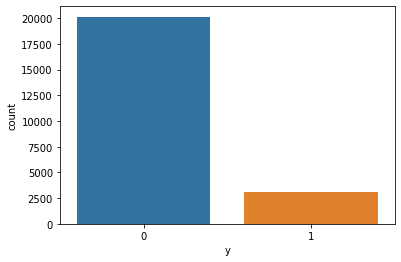

In [260]:
sns.countplot(data=swimmers, x='y')

- Классы не сбалансированы

In [261]:
swimmers.groupby('y').mean()

,ID,Age,Height,Weight,Year,is_home_advantage
y,,,,,,
0,68045.812032,20.513233,178.261898,70.259692,1984.700749,0.058073
1,70973.935696,20.920900,180.549103,72.761829,1978.164698,0.131890


- Средний возраст, рост и вес выигравших медаль атлетов больше, чем у тех, кто медаль не получил
- Домашнее преимущество чаще встречается у тех, кто взял призовое место

**Sex**

<AxesSubplot:xlabel='Sex'>

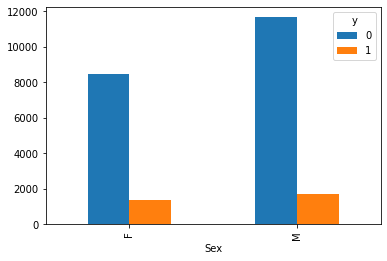

In [262]:
pd.crosstab(swimmers.Sex, swimmers.y).plot(kind='bar')

Соотношение медалей различно для мужчин и женщин, признак пола может оказаться хорошим прогнозирующим фактором

**Age**

C:\Users\1\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



<AxesSubplot:xlabel='Age'>

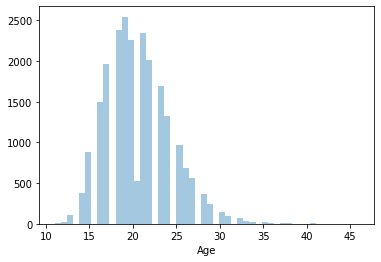

In [282]:
sns.distplot(swimmers.Age, kde=False)

- Большинство участников находятся в возрасте от 15 до 25 лет

**Region**

In [264]:
swimmers.region.nunique()

186

Так как градаций этой категориальной переменной слишком много, оставим топ-15 стран по медалям, а остальных заменим на 'Other'

In [265]:
# найдем топ 15 команд по сумме наград
top_15 = swimmers.groupby(['region'], as_index=False).agg(medal_cnt=('Medal', 'count'))
top_15 = top_15.sort_values(by=['medal_cnt', 'region'], ascending=[False, True]).head(15).region
top_15

173             USA
9         Australia
61          Germany
139          Russia
172              UK
83            Japan
118     Netherlands
30           Canada
71          Hungary
57           France
34            China
159          Sweden
80            Italy
152    South Africa
45          Denmark
Name: region, dtype: object

In [266]:
swimmers['Team_Country'] = swimmers['region'].apply(lambda x: 'Other' if x not in list(top_15) else x)

In [267]:
swimmers.Team_Country.nunique()

16

Теперь будем использовать переменную Team_Country вместо region для предсказания

## Создание dummy переменных

In [268]:
data = swimmers[['Sex', 'Age', 'Height', 'Weight', 'Team_Country', 'is_home_advantage', 'distance_category', 'y']]
data = pd.get_dummies(data, columns=['Sex', 'Team_Country', 'distance_category'], drop_first=True)

## Устранение дисбаланса классов при помощи SMOTE

In [269]:
!pip install imblearn

SMOTE:

- создаёт синтетические образцы на основе выборок минорного класса (не получивших медалей) вместо создания их копий;
- случайно выбирает одного из ближайших k-соседей и использует его для создания схожих, но случайно изменённых новых сведений.

In [270]:
X = data.loc[:, data.columns != 'y']
y = data.loc[:, data.columns == 'y']

In [271]:
from imblearn.over_sampling import SMOTE

os = SMOTE(random_state=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns

os_data_X, os_data_y = os.fit_resample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X, columns=columns)
os_data_y = pd.DataFrame(data=os_data_y, columns=['y'])

# Мы можем проверить числа наших данных
print("Размер пересемплированных данных ", len(os_data_X))
print("Количество заплывов без медалей в пересемплированных данных", len(os_data_y[os_data_y['y'] == 0]))
print("Количество медалей в пересемплированных данных", len(os_data_y[os_data_y['y'] == 1]))
print("Пропорция не награжденных в пересемплированных данных ", len(os_data_y[os_data_y['y'] == 0]) / len(os_data_X))
print("Пропорция награжденных в пересемплированных данных ", len(os_data_y[os_data_y['y'] == 1]) / len(os_data_X))

Размер пересемплированных данных  28174
Количество заплывов без медалей в пересемплированных данных 14087
Количество медалей в пересемплированных данных 14087
Пропорция не награжденных в пересемплированных данных  0.5
Пропорция награжденных в пересемплированных данных  0.5


- over-sampling выполняется только для обучающих данных, так как в таком случае информация из теста не используется для составления новых экземпляров данных

## Рекурсивное устранение признаков

Рекурсивное устранение признаков (RFE) основывается на повторяющемся конструировании модели и выборе лучше всех или хуже всех выполняемого признака, отделения этого признака и повторения цикла с оставшимися. Этот процесс применяется, пока в наборе данных не закончатся признаки. Цель RFE заключается в отборе признаков посредством рекурсивного рассмотрения всё меньшего и меньшего их набора.

In [272]:
# data_final_vars = data.columns.values.tolist()
# y = ['y']
# X = [i for i in data_final_vars if i not in y]

# from sklearn.feature_selection import RFE
# from sklearn.linear_model import LogisticRegression

# logreg = LogisticRegression(solver='lbfgs', max_iter=3000)
# rfe = RFE(logreg, n_features_to_select=20) #оставим 20 признаков
# rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
# print(rfe.support_)
# print(rfe.ranking_)

## Попробуем предсказать получит ли медаль спортсмен в своем заплыве

In [273]:
import statsmodels.api as sm
logit_model=sm.Logit(os_data_y['y'], os_data_X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.337805
         Iterations 7
                              Results: Logit
Model:                 Logit               Pseudo R-squared:    0.513     
Dependent Variable:    y                   AIC:                 19078.6588
Date:                  2023-04-24 10:35    BIC:                 19260.0742
No. Observations:      28174               Log-Likelihood:      -9517.3   
Df Model:              21                  LL-Null:             -19529.   
Df Residuals:          28152               LLR p-value:         0.0000    
Converged:             1.0000              Scale:               1.0000    
No. Iterations:        7.0000                                             
--------------------------------------------------------------------------
                           Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
--------------------------------------------------------------------------
Age                        0

## Подгонка модели логистической регрессии

In [274]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
X_train, X_test, y_train, y_test = train_test_split(os_data_X, os_data_y['y'], test_size=0.3, random_state=0)
logreg = LogisticRegression(solver='lbfgs', max_iter=3000)
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=3000)

**Прогнозирование результатов тестового набора и вычисление точности.**

In [275]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.86


Точность классификатора логистической регрессии для тестового набора: 0,86.

**Матрица ошибок**

In [276]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[3743  452]
 [ 739 3519]]


Результат показывает, что у нас 3743+3519 верных прогнозов и 739+452 ошибочных.

**Вычисление точности, полноты, F-меры и поддержки**

Показатель F-бета можно интерпретировать как взвешенное гармоническое среднее точности и полноты, где лучшим значением этого показателя будет 1, а худшим 0.

Показатель F-бета определяет, насколько значимость полноты больше, чем точности, опираясь на фактор бета. Например, beta = 1.0 означает, что полнота и точность равно важны.

Поддержка — это число вхождений каждого класса в y_test.

In [277]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.89      0.86      4195
           1       0.89      0.83      0.86      4258

    accuracy                           0.86      8453
   macro avg       0.86      0.86      0.86      8453
weighted avg       0.86      0.86      0.86      8453



**ROC-кривая**

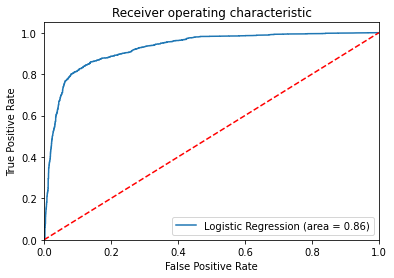

In [278]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()